# The Influence of Viscosity on Present-Day GL Position

# 1. Load Dataset

In [1]:
import xarray as xr
import gcsfs
gcs = gcsfs.GCSFileSystem(token=None, access='read_only')

In [2]:
snapshots1ka = xr.open_zarr(gcs.get_mapper('gs://ldeo-glaciology/paleo_ensemble/snapshots1ka.zarr'))
snapshots1ka = snapshots1ka.chunk(chunks={'time':1})

In [3]:
# Add these codes to decrease CPU and memory use, which avoids the workers from being killed.
from dask.distributed import Client
import dask_gateway

gateway = dask_gateway.Gateway()

# Close existing clusters
open_clusters = gateway.list_clusters()
print(list(open_clusters))
if len(open_clusters)>0:
    for c in open_clusters:
         cluster = gateway.connect(c.name)
         cluster.shutdown()  

# Increase worker memory
options = gateway.cluster_options()
options.worker_memory = 16

cluster = gateway.new_cluster(cluster_options=options)

[]


In [4]:
# Start up cloud cluster with 20 workers
cluster.scale(20)
client = Client(cluster)

# Varying Viscosity

At first, the viscosity is varied in present time with the following combination of variables: SIA enhancement factor = 2.0, q = 0.75, precipitation scaling factor = 2%/degree C. The selected section is (-1.5e6, 1.5e6) to (-0.7e6, 0).

In [97]:
# Define section
x_p = [-1.5e6, -0.7e6]
y_p = [1.5e6, 0]

In [98]:
def extract_profile1(visc):
    import numpy as np
    # Define the x coordinates for the 1000 points between the two selected points
    x = np.linspace(x_p[0], x_p[1], 1000)
    # Define the y coordinates for the 1000 points between the two selected points
    y = np.linspace(y_p[0], y_p[1], 1000)

    # Create xarray datasets
    x = xr.DataArray(x, dims="number")
    y = xr.DataArray(y , dims="number")
    
    # Ice type advanced interpolation
    ice = snapshots1ka.mask.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=visc).interp(x=x, y=y).values
        
    # GL position
    print("GL position", np.max(np.where(ice > 2.5)))
    I_gl = np.max(np.where(ice > 2.5))
    x_g = x[I_gl]
    y_g = y[I_gl]
    
    print("x coordinate:", x_g)
    print("y coordinate:", y_g)
    
    # Visualize GL position
    import matplotlib.pyplot as plt
    snapshots1ka.mask.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=visc).plot(x='x',y='y',size = 5)
    plt.plot(x_p,y_p,color="red", lw=3)
    plt.plot(x[I_gl], y[I_gl], color="blue", markersize=10,marker="o") 
    plt.savefig('my_plot.png')

In [137]:
def extract_profile2(visc):
    import numpy as np
    # Define the x coordinates for the 1000 points between the two selected points
    x = np.linspace(x_p[0], x_p[1], 1000)
    # Define the y coordinates for the 1000 points between the two selected points
    y = np.linspace(y_p[0], y_p[1], 1000)

    # Create xarray datasets
    x = xr.DataArray(x, dims="number")
    y = xr.DataArray(y , dims="number")
    
    # Ice type advanced interpolation
    ice = snapshots1ka.mask.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=visc).interp(x=x, y=y).values
        
    # GL position
    I_gl = np.max(np.where(ice > 2.5))
    x_g = x[I_gl]
    y_g = y[I_gl]
    
    # Create a list that has the same number of elements as x
    distance = list(range(len(x)))
    GLx = x[I_gl].item()
    GLy = y[I_gl].item()

    for i in range(0,I_gl):
        dist = (x[i].item()-GLx)**2 + (y[i].item()-GLy)**2
        distance[i] = np.sqrt(dist) /1000

    for i in range(I_gl, len(x)):
        dist = (x[i].item()-GLx)**2 + (y[i].item()-GLy)**2
        distance[i] = -np.sqrt(dist) / 1000

    # Bedrock surface elevation advanced interpolation
    bed = snapshots1ka.topg.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=visc).interp(x=x, y=y).values
    
    # Ice thickness advanced interpolation
    ice = snapshots1ka.thk.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=visc).interp(x=x, y=y).values
    
    # Ice upper surface advanced interpolation
    surface = snapshots1ka.usurf.isel(time=124, par_esia=1, par_ppq=2, par_prec=0, par_visc=visc).interp(x=x, y=y).values
    
    # Lower level
    low = surface - ice
    
    # Plot cross section
    import matplotlib.pyplot as plt
    plt.plot(distance, bed, color="black", label="Bedrock Surface Elevation")
    plt.plot(distance, surface, color="blue", label="Ice Upper Surface Elevation")
    plt.plot(distance, low, color="blue", linestyle="--")
    plt.axhline(y = 0, color = 'black', linestyle = '--')
    plt.fill_between(distance, surface, low, color='aqua')
    plt.xlabel("Distance from Present-Day GL (km)")
    plt.ylabel("Elevation (m a.s.l.)")
    plt.title("Weddell Sea Sector (0 kyr BP)")
    plt.legend()
    plt.show()

## Viscosity = 1.0e20

GL position 210
x coordinate: <xarray.DataArray ()>
array(-1331831.83183183)
y coordinate: <xarray.DataArray ()>
array(1184684.68468468)


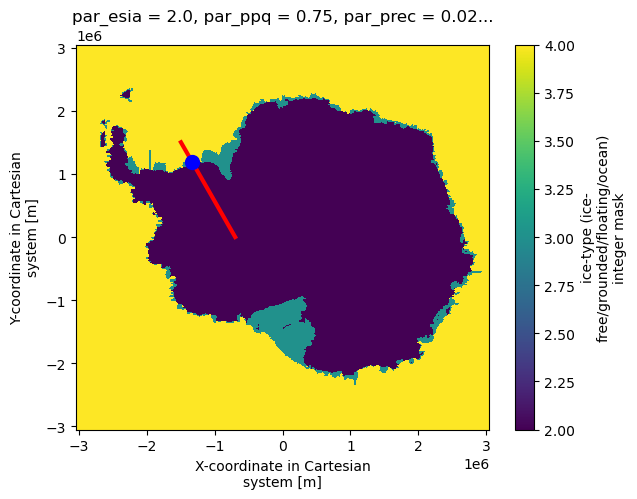

In [122]:
extract_profile1(0)

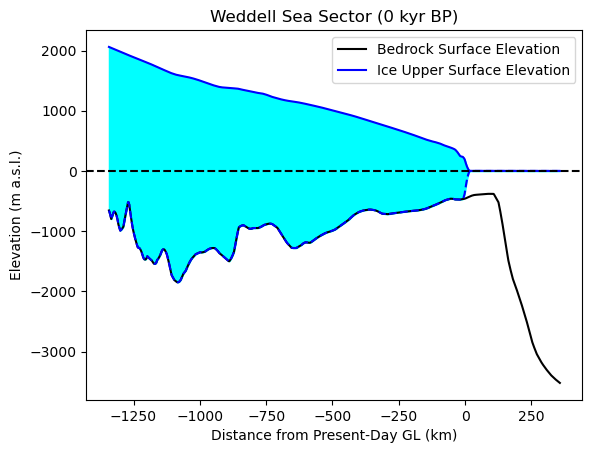

In [138]:
extract_profile2(0)

## Viscosity = 5.0e20

GL position 875
x coordinate: <xarray.DataArray ()>
array(-799299.2992993)
y coordinate: <xarray.DataArray ()>
array(186186.18618619)


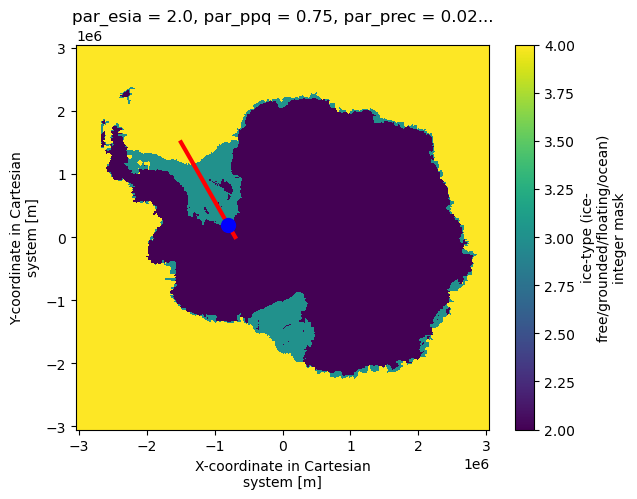

In [115]:
extract_profile1(1)

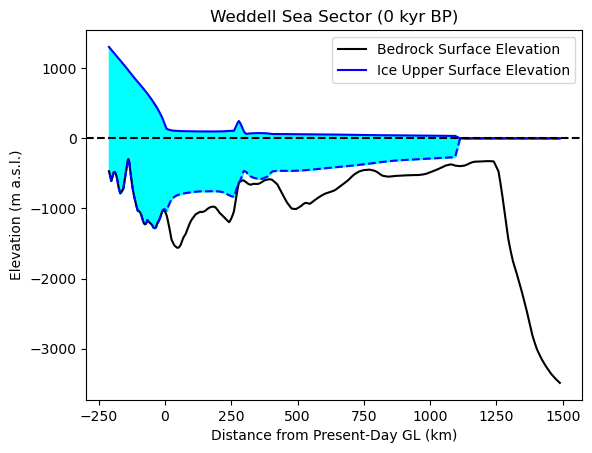

In [139]:
extract_profile2(1)

## Viscosity = 2.5e21

GL position 424
x coordinate: <xarray.DataArray ()>
array(-1160460.46046046)
y coordinate: <xarray.DataArray ()>
array(863363.36336336)


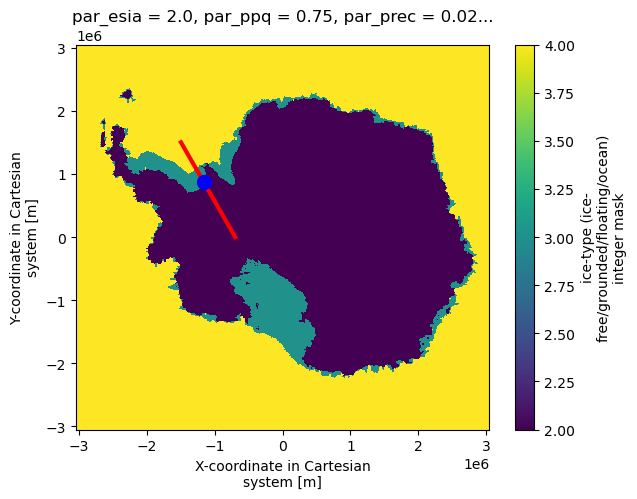

In [117]:
extract_profile1(2)

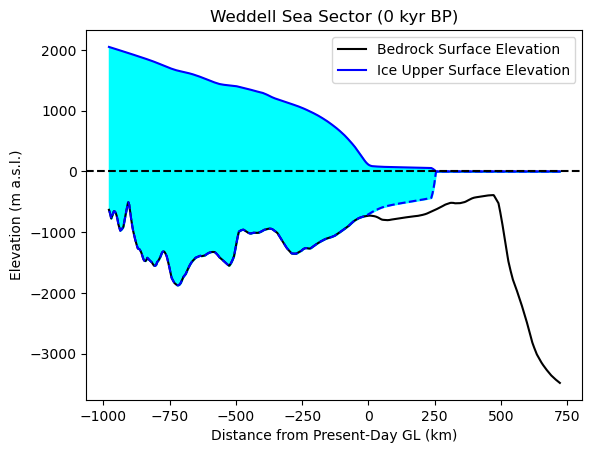

In [140]:
extract_profile2(2)

## Viscosity = 1.0e22

GL position 909
x coordinate: <xarray.DataArray ()>
array(-772072.07207207)
y coordinate: <xarray.DataArray ()>
array(135135.13513514)


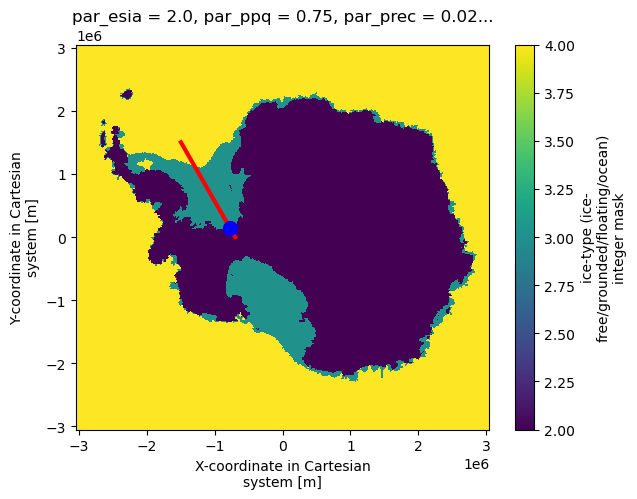

In [119]:
extract_profile1(3)

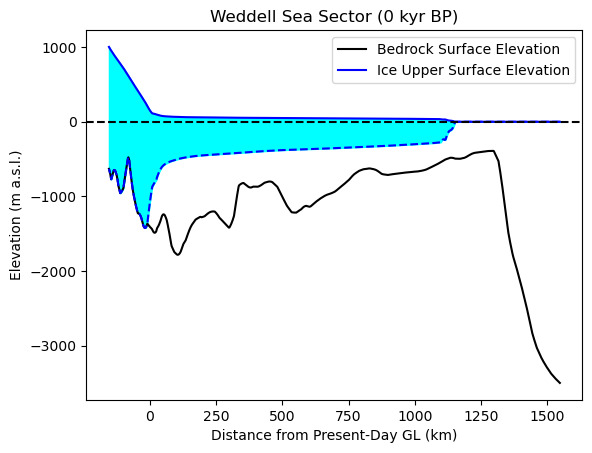

In [141]:
extract_profile2(3)

By only varying the viscosity, the position of the grounding line and the volume of the ice sheet varied largely. The basic topography of the bedrock and the extent of ice are very similar for all vidcosities in the present time stamp. Therefore, it can be inferred that the difference in time delay of the response of the mantle to the ice mass above it created the large difference in the thickness of the ice sheet and the position of the grounding line.
Ice mass was the largest and the grounding line extended the furthest for the lowest viscosity ($\mu$ = 1.0e20 Pa s) scenario. When the viscosity was increased to 5.0e20 Pa s, the grounding line retreated by more than 1 km, and the volume of the ice decreased largely. Interestingly, when the viscosity was increased again to 2.5e21 Pa s, the grounding line advanced by roughly 750 m, and the ice volume increased largely as well. In the highest viscosity ($\mu$ = 1.0e22 Pa s) scenario, the grounding line had retreated the furhtest, and the ice volume was the smallest.

There are two important implications from these plots. Firstly, out of the four viscosities that were examined ($\mu$ = 1.0e20 Pa s, 5.0e20 Pa s, 2.5e21 Pa s, and 1.0e22), the viscosity $\mu$ = 1.0e20 Pa s is inferred to be the best value to make the WAIS robust. In fact, from the ice type plot, it is clearly visible that the grounding line extends the furthest not only in the Weddell Sea but also in the Ross Sea sector. Moreover, at least in the section investigated here, $\mu$ = 1.0e20 Pa s was the only scenario that had no basal melting from the intrusion of warm deep water, which could explain the stability of the ice sheet. Since lower viscosity is associated with faster GIA, this result could imply that rapid response of the bedrock to the change in ice mass above it is more ideal for the stability of the WAIS.

Another implication is that butressing of ice shelves could possibly be stimulating the regrowth of ice sheets. With viscosity $\mu$ = 5.0e20 Pa s, the Henry Ice Rise has been formed by a local high elevation of the bedrock at roughly 300-450 m seaward from the grounding line, and the butressing is apparently blocking further intrusion of the warm deep water. There are also signs of lithospheric rebound at roughly 750 m and 1100 m seaward from the grounding line, which could possibly be butressing the ice shelf in the future. In fact, the bedrock topography in these regions is very similar to that of the scenario with viscosity $\mu$ = 2.5e21 Pa s, but the bedrock elevation is higher. This could imply that less ice-shelf grounding of the $\mu$ = 5.0e20 Pa s scenario compared to the $\mu$ = 1.0e20 Pa s scenario is due to insufficient elapsing time for the lithosphere to rebound, and that with sufficient time, the ice sheet will readvance to a position similar to the $\mu$ = 1.0e20 Pa s. If this hypothesis is true, it can explain the irregular pattern of the position of the grounding line created by the variation in viscosity.

However, there are limitations to this study as well. Since only four viscosity values are investigated, it cannot be determined whether the optimal viscosity for the WAIS stability is above or below 1.0e20 Pa s. From the irregularity in the advance and retreat of the grounding line in the four viscosities that were invesitgated, it is still possible that the grounding line extendsthe furthest at a viscosity value larger than $\mu$ = 1.0e22 Pa s. In addition, this analysis is only true when the SIA enahncement factor, q, and the precipitation scaling factor are fixed at 2.0, 0.75, and 2%/degree, respectively. Since no other viscosity values are available in the current model, I intend to investigate the grounding line position at the same cross section with the ensemble-wide averaged SIA enahncement factor, q, and precipitation scaling factor values as my next step.